# IBM AI Workflow Specialization Capstone #
## Assimilating The Business Opportunity And Articulate Testable Hypotheses ##

The management at AAVAIL wants to know whether their alternative approaches to generating revenue have ultimately been successful or not. They have a sizable amount of data over a reasonable amount of time, but aren't quite sure what to make of said data. They want a predictive model that will be able to predict the revenue for the following month, and additionally they want the ability for the service to predict projected revenue for specific countries in the dataset. 

The results are expected to be more accurate than the current model that they are using. 

### Potential hypotheses ###

There are a number of potential hypotheses that could be tested. It ultimately depends on the quality and complexity of the data that was collected. 
<ul>
<li>The amount of revenue generated for each month can be modelled as a Bayesian model, where the revenue for each month is dependent on the revenue of the previous month(s) and several other factors.</li>
<li>Revenue per month can also be correlated with the amount of content streamed per each individual user and average time of engagement with content on the platform in the previous month(s).</li>
<li>Revenue per month can also be correlated with the average amount of unique content streamed per each individual user in each of the previous month(s).</li>
</ul>

### Data needed to address each hypothesis ###

Ultimately the data that we need to address each of the hypotheses are as follows:

<ul>
<li>For modelling the amount of revenue generated for each month, we need the time of each stream aggregated by month and the total amount of money spent per invoice per month.</li>
<li>Modelling the amount of content streamed per each individual user simply requires counting all of the entries in a database and grouping them by user_id.</li>
<li>Calculating the average time of engagement with content on the platform is highly dependent on the amount of data that we have available. A simple start and end times for each stream might suffice, but in the case where that data isn't available, a good fallback would be the length/runtime of each piece of content that the user purchased.</li>
<li>Calculating the average amount of unique content streamed per each individual user simply requires aggregating over the dataset and grouping by the content_id and the user_id.</li>
</ul>

## Data ingestion ##

In [1]:
%%writefile load_data.py
import json
import glob
import pandas as pd
def load_data(pathname):
#load data
    data = []
    for filename in glob.glob(f"{pathname}/*.json"):
        with open(filename, "r") as file:
            for line in file:
                entry = json.loads(line)
                data += entry
    df = pd.DataFrame(data)
    return df

Overwriting load_data.py


In [1]:
#do a bit of EDA on the data before we can 
import pandas as pd
import numpy as np
import pygwalker as pyg
from load_data import load_data
from clean_data import clean_data

## Load and clean data ##

In [3]:
DATA_DIR = "cs-train"
df = load_data(DATA_DIR)
df = clean_data(df)
print(df.head(5))

          country  customer_id invoice stream_id  times_viewed  year month  \
0  United Kingdom      18288.0  489434     85048          12.0  2017    11   
1  United Kingdom      18289.0  489597     22130           1.0  2017    11   
2  United Kingdom      18289.0  489597     22132           6.0  2017    11   
3  United Kingdom      18289.0  489597     22133           4.0  2017    11   
4  United Kingdom      18289.0  489597     22134           1.0  2017    11   

   total_price       date  total_revenue  
0         6.95 2017-11-28          83.40  
1         8.65 2017-11-28           8.65  
2         1.70 2017-11-28          10.20  
3         1.70 2017-11-28           6.80  
4         0.87 2017-11-28           0.87  


### Explore "POST" stream_id artifact ###

In [30]:
#load fresh dataset
df = load_data(DATA_DIR)
post = df[df["stream_id"]=="POST"]
print(post[post["customer_id"].isna()])

               country  customer_id  invoice  ...  total_price StreamID  TimesViewed
10209   United Kingdom          NaN   490344  ...        18.00      NaN          NaN
10532   United Kingdom          NaN  C490307  ...         8.97      NaN          NaN
39235   United Kingdom          NaN   492531  ...         3.95      NaN          NaN
572051  United Kingdom          NaN  C540266  ...        35.09      NaN          NaN
578631  United Kingdom          NaN   540699  ...         0.00      NaN          NaN
590868  United Kingdom          NaN   541607  ...        29.43      NaN          NaN
600053  United Kingdom          NaN  C542540  ...         4.41      NaN          NaN
641761  United Kingdom          NaN   546303  ...          NaN      NaN          NaN
661982  United Kingdom          NaN  C547913  ...          NaN      NaN          NaN
662021  United Kingdom          NaN  C547915  ...          NaN      NaN          NaN
662028  United Kingdom          NaN  C547905  ...          NaN   

### Consolidate duplicate columns and missing values among DataFrame ###

There are duplicate columns in stream_id and StreamID, total_price and price, and times_viewed and TimesViewed which can all be consolidated into one larger DataFrame

In [2]:
print(df.columns)
print(len(df))
#get the number of columns where both stream id columns are empty
#we have all stream ids
num_stream_ids = len(df[(~df["stream_id"].isna())|(~df["StreamID"].isna())])
print(f"Entries with a proper stream id: {num_stream_ids}")
df["stream_id"] = df["stream_id"].fillna(df["StreamID"])
#we have the full price data for each purchase in the dataset
num_prices = len(df[(~df["total_price"].isna())|(~df["price"].isna())])
print(f"Entries with a proper price: {num_prices}")
df["total_price"] = df["total_price"].fillna(df["price"])
#how much of times_viewed are we missing?
num_times_viewed = len(df[(~df["times_viewed"].isna())|(~df["TimesViewed"].isna())])
print(f"Entries with a proper times_viewed: {num_times_viewed}")
df["times_viewed"] = df["times_viewed"].fillna(df["TimesViewed"])

assert len(df[df["stream_id"].isna()]) == 0
assert len(df[df["total_price"].isna()]) == 0
assert len(df[df["times_viewed"].isna()]) == 0
print("No empty fields in columns stream_id, total_price, times_viewed")

Index(['country', 'customer_id', 'invoice', 'price', 'stream_id',
       'times_viewed', 'year', 'month', 'day', 'total_price', 'StreamID',
       'TimesViewed'],
      dtype='object')
815011
Entries with a proper stream id: 815011
Entries with a proper price: 815011
Entries with a proper times_viewed: 815011
No empty fields in columns stream_id, total_price, times_viewed


### Create Date Column ###

In [4]:
#merge the day, month and year fields into one date column
df["date"] = pd.to_datetime(df[["day", "month", "year"]])
print(df.head(5))

          country  customer_id invoice  price stream_id  times_viewed  year  \
0  United Kingdom      13085.0  489434   6.95     85048          12.0  2017   
1  United Kingdom          NaN  489597   8.65     22130           1.0  2017   
2  United Kingdom          NaN  489597   1.70     22132           6.0  2017   
3  United Kingdom          NaN  489597   1.70     22133           4.0  2017   
4  United Kingdom          NaN  489597   0.87     22134           1.0  2017   

  month day  total_price StreamID  TimesViewed       date  
0    11  28         6.95      NaN          NaN 2017-11-28  
1    11  28         8.65      NaN          NaN 2017-11-28  
2    11  28         1.70      NaN          NaN 2017-11-28  
3    11  28         1.70      NaN          NaN 2017-11-28  
4    11  28         0.87      NaN          NaN 2017-11-28  


### Drop unnecesaary extra columns ###

In [5]:
#now let's create a new clean dataframe with all of the relevant information
df = df.drop(["StreamID", "TimesViewed", "price", "year", "month", "day"], axis=1)
print(df.head(5))
print(len(df))

          country  customer_id invoice stream_id  times_viewed  total_price  \
0  United Kingdom      13085.0  489434     85048          12.0         6.95   
1  United Kingdom          NaN  489597     22130           1.0         8.65   
2  United Kingdom          NaN  489597     22132           6.0         1.70   
3  United Kingdom          NaN  489597     22133           4.0         1.70   
4  United Kingdom          NaN  489597     22134           1.0         0.87   

        date  
0 2017-11-28  
1 2017-11-28  
2 2017-11-28  
3 2017-11-28  
4 2017-11-28  
815011


### Create total_revenue column ###

In [6]:
#and now we aggregate the data and group by country and summary statistics
#first need to create a new column that has the total revenue generated per each individual stream
df["total_revenue"] = df.apply(lambda x: x["total_price"]*x["times_viewed"], axis=1)
print(df["total_revenue"])


0         83.40
1          8.65
2         10.20
3          6.80
4          0.87
          ...  
815006    10.20
815007    15.60
815008     9.96
815009    14.85
815010    19.80
Name: total_revenue, Length: 815011, dtype: float64


### Determine how much time our dataset spans ###

In [7]:
#Get the window of time
min_date = df["date"].min()
max_date = df["date"].max()
print(min_date)
print(max_date)

2017-11-28 00:00:00
2019-07-31 00:00:00


### Deal with missing customer id values ###

We are also missing quite a number of customer_ids as well, which isn't a bad thing since we can simply reconstruct the number of users based on each individual invoice. It is a big deal, however, in terms of the hypotheses I had proposed above.

This is a sanity check to make sure that every unique invoice appears under only one user.

In [3]:
#Now we take a look at the customer id data
missing = df[df["customer_id"].isna()]
print(missing.head(5))
print(len(missing))
invoices = missing[missing["invoice"]=="489597"]["customer_id"].unique()
print(invoices)

          country  customer_id invoice  price stream_id  times_viewed  year  \
1  United Kingdom          NaN  489597   8.65     22130           1.0  2017   
2  United Kingdom          NaN  489597   1.70     22132           6.0  2017   
3  United Kingdom          NaN  489597   1.70     22133           4.0  2017   
4  United Kingdom          NaN  489597   0.87     22134           1.0  2017   
5  United Kingdom          NaN  489597   0.87     22135           1.0  2017   

  month day  total_price StreamID  TimesViewed  
1    11  28         8.65      NaN          NaN  
2    11  28         1.70      NaN          NaN  
3    11  28         1.70      NaN          NaN  
4    11  28         0.87      NaN          NaN  
5    11  28         0.87      NaN          NaN  
189762
[nan]


In [24]:
users = df[["invoice", "customer_id"]]
ids_per_invoice = users.drop_duplicates().groupby(["invoice"]).count().sort_values(by=["customer_id"], ascending=False)
print(ids_per_invoice)
num_invoices = len(ids_per_invoice)
assert len(ids_per_invoice[(ids_per_invoice["customer_id"]==1)|(ids_per_invoice["customer_id"]==0)]) == num_invoices

         customer_id
invoice             
489434             1
547402             1
547404             1
547405             1
547406             1
...              ...
517971             1
517972             1
517973             1
517974             1
C562267            1

[42646 rows x 1 columns]


In [23]:
#replace missing customer_id values with new_values
max_id = df["customer_id"].max()
print(max_id)
missing_ids = len(ids_per_invoice[ids_per_invoice["customer_id"]==0])
unique_invoices = df['invoice'].unique()
existing_customer_ids = df['customer_id'].dropna().unique()
new_customer_ids = [max_id+i for i in range(1, len(unique_invoices) + 1)]
invoice_to_int_mapping = {invoice: new_id for invoice, new_id in zip(unique_invoices, new_customer_ids)}

# Fill missing "customer_id" values using the mapping
df['customer_id'] = df['invoice'].map(invoice_to_int_mapping)
print(len(df["customer_id"].unique()))

60933.0
42646


In [25]:
#verify that above code actually works
users = df[["invoice", "customer_id"]]
ids_per_invoice = users.drop_duplicates().groupby(["invoice"]).count().sort_values(by=["customer_id"], ascending=False)
print(ids_per_invoice)
num_invoices = len(ids_per_invoice)
assert len(ids_per_invoice[(ids_per_invoice["customer_id"]==1)]) == num_invoices

         customer_id
invoice             
489434             1
547402             1
547404             1
547405             1
547406             1
...              ...
517971             1
517972             1
517973             1
517974             1
C562267            1

[42646 rows x 1 columns]


### Writing all of the above code to a clean data file ###

In [32]:
%%writefile clean_data.py
import pandas as pd
#write all of the above cells into one file
def clean_data(df):
    df["stream_id"] = df["stream_id"].fillna(df["StreamID"])
    df["total_price"] = df["total_price"].fillna(df["price"])
    df["times_viewed"] = df["times_viewed"].fillna(df["TimesViewed"])
    df["date"] = pd.to_datetime(df[["day", "month", "year"]])
    df = df.drop(["StreamID", "TimesViewed", "price", "day"], axis=1)
    #compute total revenue
    df["total_revenue"] = df.apply(lambda x: x["total_price"]*x["times_viewed"], axis=1)

    #fix missing customer ids
    max_id = df["customer_id"].max()
    users = df[["invoice", "customer_id"]]
    ids_per_invoice = users.drop_duplicates().groupby(["invoice"]).count().sort_values(by=["customer_id"], ascending=False)
    missing_ids = len(ids_per_invoice[ids_per_invoice["customer_id"]==0])
    unique_invoices = df['invoice'].unique()
    existing_customer_ids = df['customer_id'].dropna().unique()
    new_customer_ids = [max_id+i for i in range(1, len(unique_invoices) + 1)]
    invoice_to_int_mapping = {invoice: new_id for invoice, new_id in zip(unique_invoices, new_customer_ids)}

    # Fill missing "customer_id" values using the mapping
    df['customer_id'] = df['invoice'].map(invoice_to_int_mapping)
    return df

Overwriting clean_data.py


## Exploratory Data Analysis ##

An important thing to note is that since we had so many missing values for the customer data, and we are assuming that every invoice corresponded to a different user, we aren't able to get as clear of a read on how many unique users AAVAIL had on a day-to-day.

Therefore, the averages should accumulated per invoice rather than per user (i.e. on average, how many distinct invoices were there per day per country?)

### Total Revenue Per Day From November 28 2017 to July 31 2019 ###

                total_revenue
country                      
United Kingdom   1.013202e+07
EIRE             3.756301e+05
Germany          2.623534e+05
France           1.844170e+05
Norway           9.108397e+04


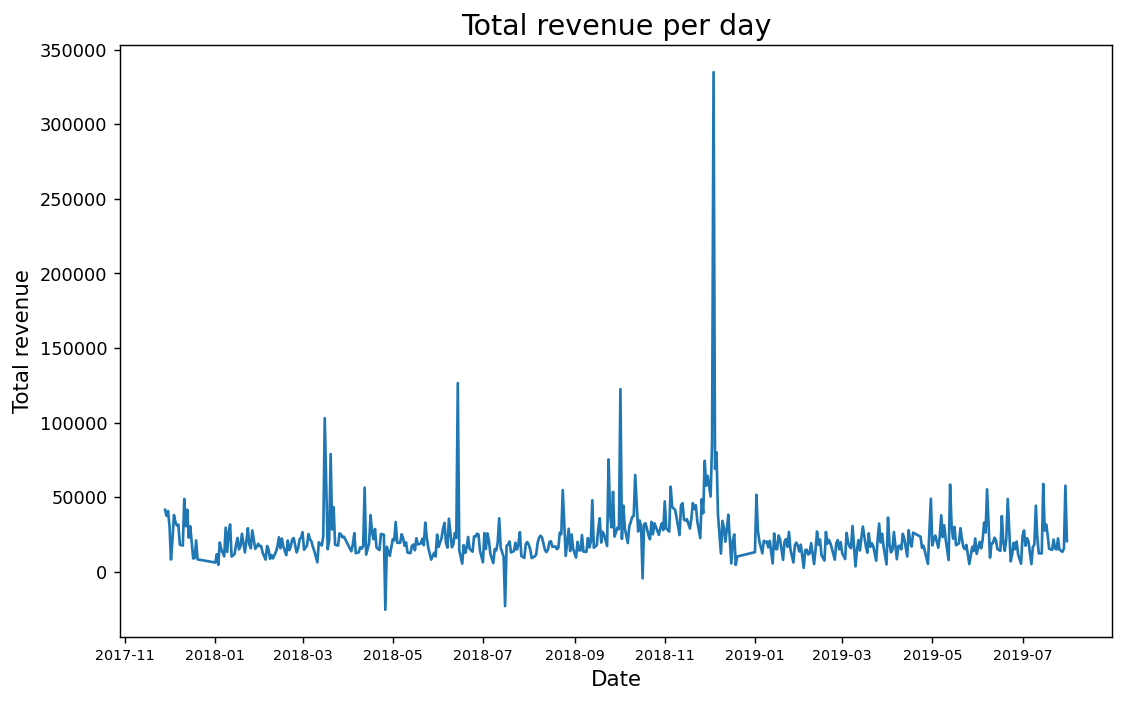

In [4]:
#aggregate each day based on the total revenue
import matplotlib.pyplot as plt

overview = df[["date", "total_revenue"]].groupby(["date"]).sum()
overview = overview.sort_values(by=["date"])
#country revenue
per_country = df[["country", "total_revenue"]].groupby(["country"]).sum().sort_values(by=["total_revenue"], ascending=False)
print(per_country.head(5))

fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(overview.index, overview["total_revenue"])
plt.title("Total revenue per day", fontdict={"fontsize": 16})
plt.xlabel("Date", fontdict={"fontsize": 12})
plt.ylabel("Total revenue", fontdict={"fontsize": 12})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

### Total Number Of Invoices Per Day From November 28 2017 to July 31 2019

            invoice
date               
2017-11-28      166
2017-11-29      133
2017-11-30      150
2017-12-01      107
2017-12-02       32
...             ...
2019-07-26       70
2019-07-28       43
2019-07-29       51
2019-07-30       61
2019-07-31       84

[495 rows x 1 columns]


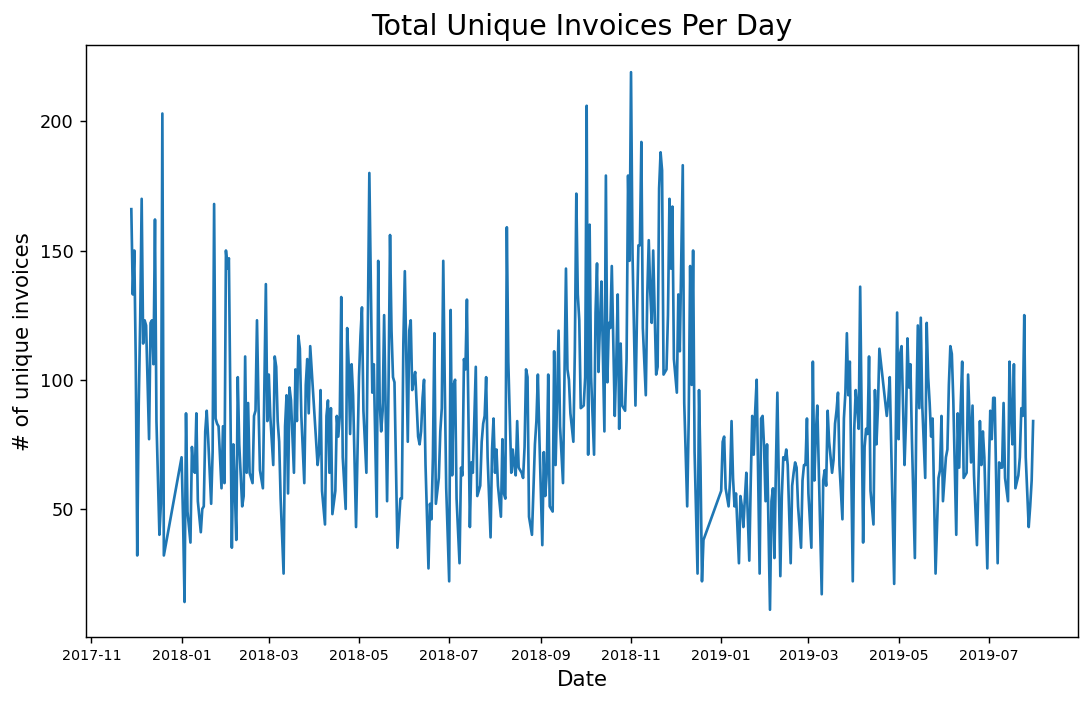

In [17]:
#aggregate each day based on the total number of invoices accounted for
count_invoices = df[["date", "invoice"]].drop_duplicates().groupby(["date"]).count().sort_values(by="date")
print(count_invoices)
fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(count_invoices.index, count_invoices["invoice"])
plt.title("Total Unique Invoices Per Day", fontdict={"fontsize": 16})
plt.xlabel("Date", fontdict={"fontsize": 12})
plt.ylabel("# of unique invoices", fontdict={"fontsize": 12})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

### Average number of items in invoice per day ###

How many items were in a particular invoice on average per day?

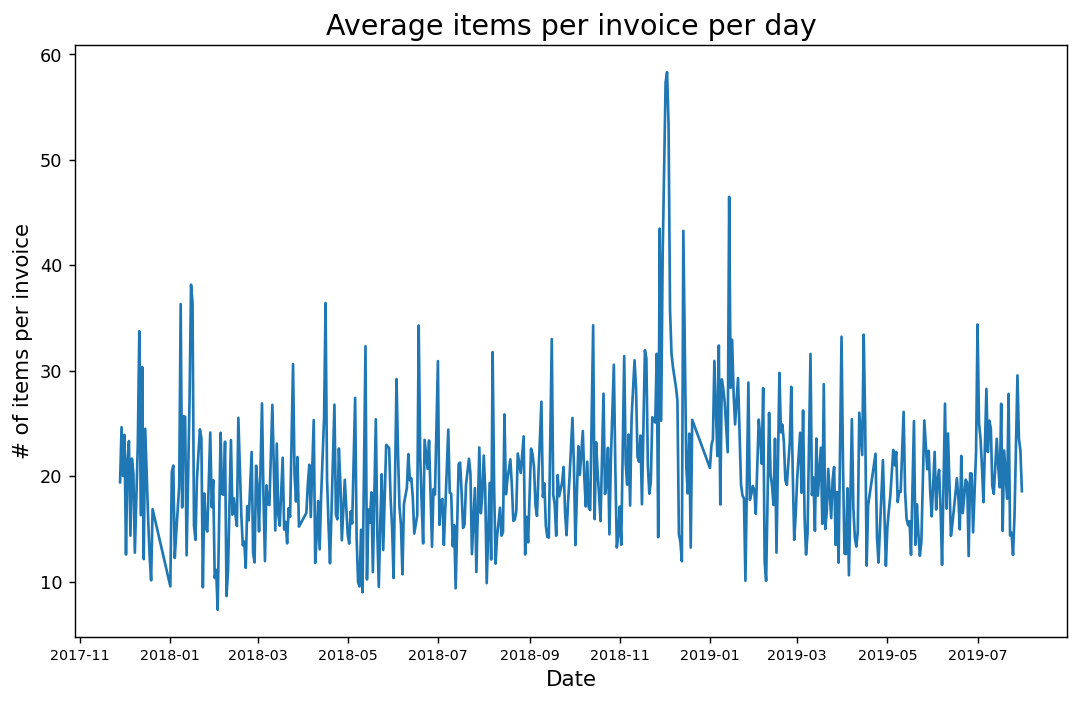

In [28]:
#first group number of invoices by day
#
avg_invoices = df[["date", "invoice"]].groupby(["date"]).count()
avg_invoices = avg_invoices.merge(count_invoices, on="date", how='inner')
avg_invoices.rename(columns={"invoice_x": "Total items per invoice", "invoice_y": "Total unique invoices"}, inplace=True)
avg_invoices["avg per invoice"] = avg_invoices.apply(lambda x: x["Total items per invoice"] / x["Total unique invoices"], axis=1)
fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(avg_invoices.index, avg_invoices["avg per invoice"])
plt.title("Average items per invoice per day", fontdict={"fontsize": 16})
plt.xlabel("Date", fontdict={"fontsize": 12})
plt.ylabel("# of items per invoice", fontdict={"fontsize": 12})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

### Total # of Unique Content Streamed Per Day From November 28 2017 to July 31 2019

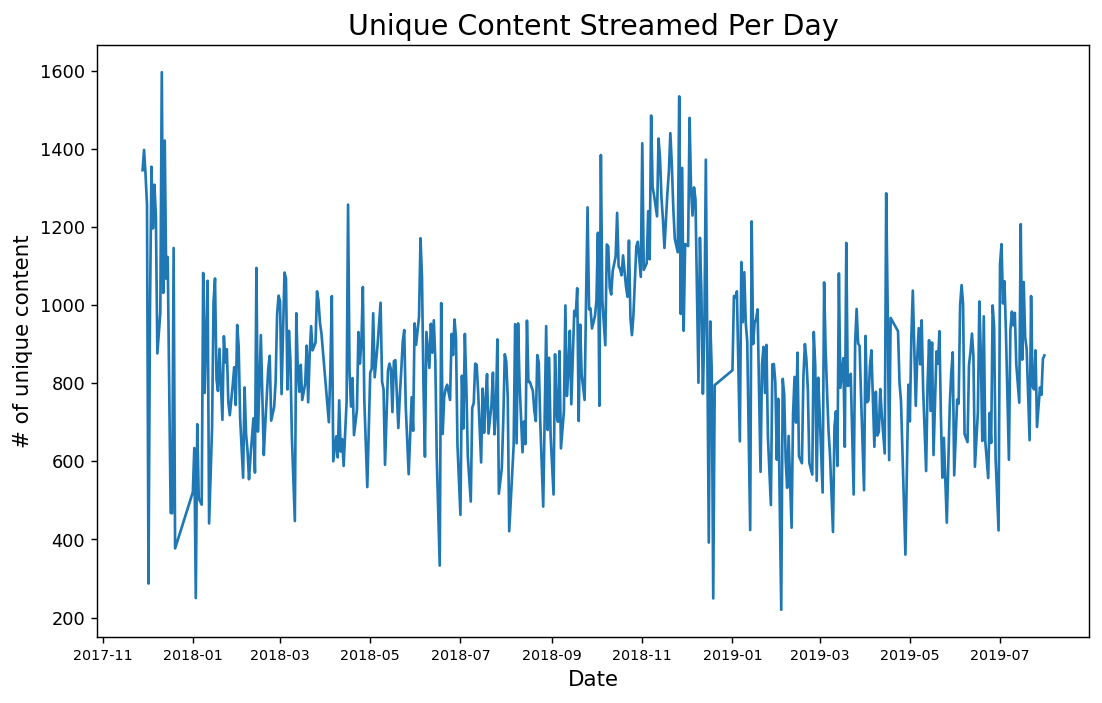

In [6]:
#let's see whether or not the *number* of unique items (stream_ids) on the streaming platform changed over time as well
#it's an assumption to think that consumers will engage will all content on the platform at any one given time
#but the sample size is indicative of how big the population is as well
count_content = df[["date", "stream_id"]].drop_duplicates().groupby(["date"]).count().sort_values(by="date")

fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(count_content.index, count_content["stream_id"])
plt.title("Unique Content Streamed Per Day", fontdict={"fontsize": 16})
plt.xlabel("Date", fontdict={"fontsize": 12})
plt.ylabel("# of unique content", fontdict={"fontsize": 12})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

In [32]:
#determine level of correlation between the total amount of revenue and the variables of interest
#concatenate all of the previously created dataframe views
merged_df = pd.DataFrame()
merged_df = count_invoices.merge(count_content, on='date', how='inner')
merged_df = merged_df.merge(overview, on="date", how="inner")
merged_df = merged_df.merge(avg_invoices, on="date", how="inner")
merged_df["date"] = merged_df.index
merged_df.drop(["Total unique invoices"], axis=1, inplace=True)
merged_df.columns = ['total invoices', '# of distinct content streamed', 'total revenue', "total items", "avg # items per invce", "date"]
print(merged_df)

            total invoices  # of distinct content streamed  total revenue  \
date                                                                        
2017-11-28             166                            1345       41623.51   
2017-11-29             133                            1397       37442.78   
2017-11-30             150                            1335       40755.15   
2017-12-01             107                            1256       30658.16   
2017-12-02              32                             287        8238.29   
...                    ...                             ...            ...   
2019-07-26              70                             688       14834.97   
2019-07-28              43                             789       13400.14   
2019-07-29              51                             770       15675.40   
2019-07-30              61                             862       57780.00   
2019-07-31              84                             871       20624.75   

There are several interesting conclusions that we can draw from these graphs.

1. The huge spike in revenue for the company around December of 2019 is also when there was a huge decline in both the number of unique content streamed per day and the number of unique invoices per day. Clearly, there might be other factors at work to determine the total revenue. 

2. There appears to be a strong correlation between the number of unique invoices per day and the amount of unique content streamed per day. This might be in part due to some colinearity, but it might be worth exploring more in the future. 

Both are these are validated in the scatterplots portrayed below

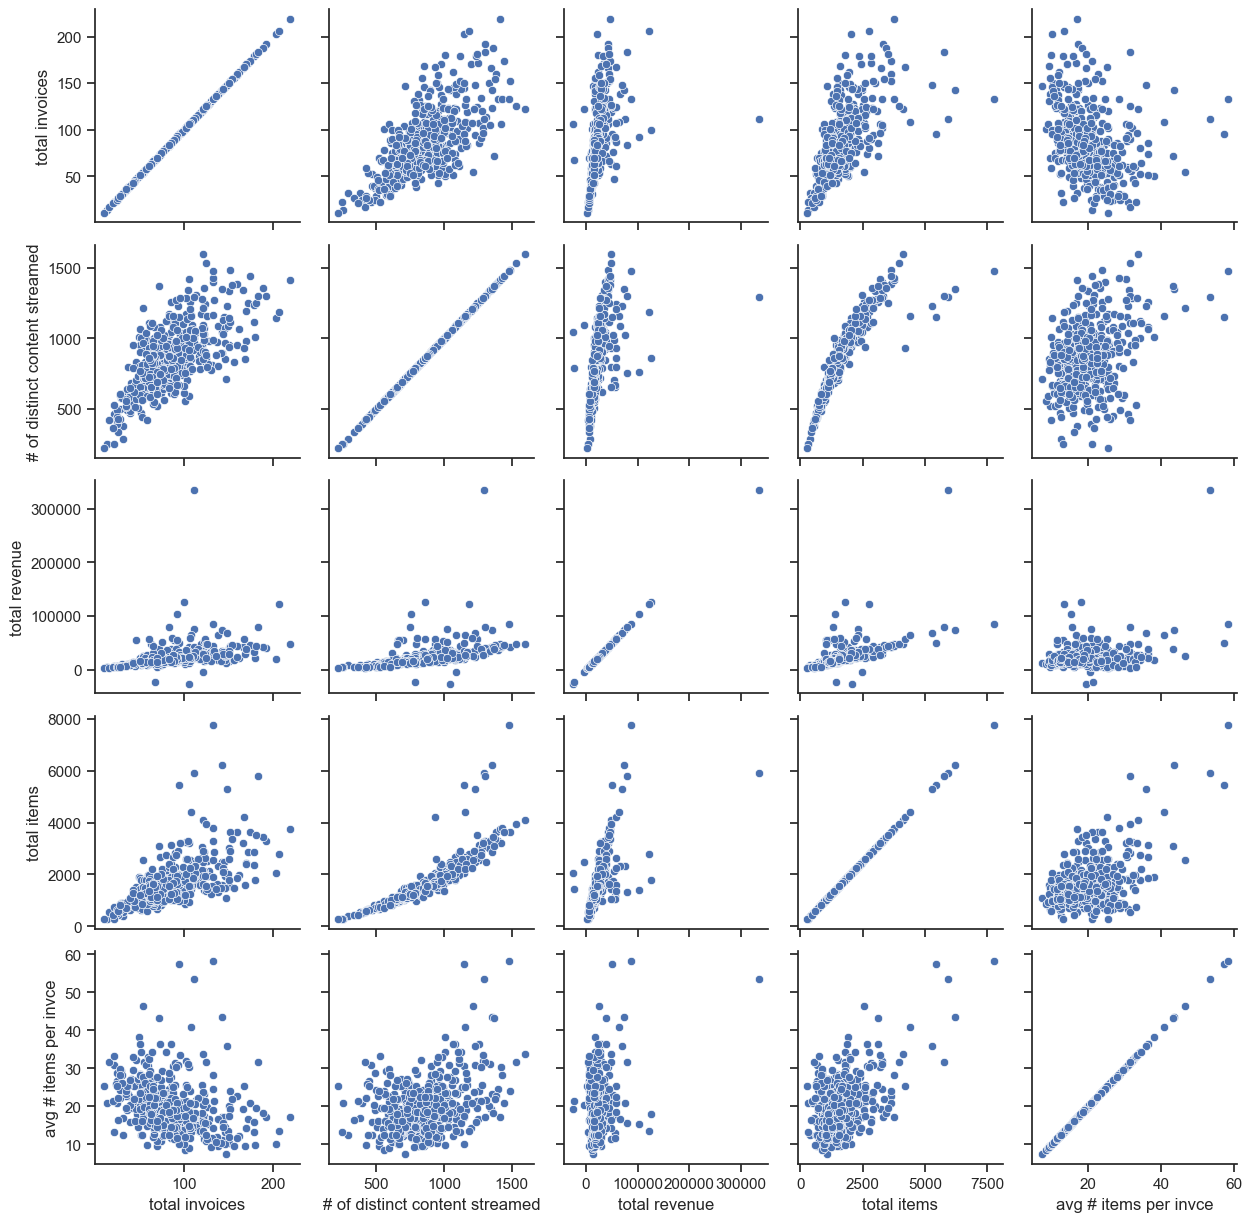

In [33]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)

## make a pair plot
columns = ['total invoices', '# of distinct content streamed', "total revenue", "total items", "avg # items per invce"]

g = sns.PairGrid(merged_df[columns])
g.map(sns.scatterplot)

## Splitting values by country ##

Since there is a good amount of data to work with now, the last step that needs to be performed is to apply all of the group_by functions by country as well. 

This code can be in a seperate cell from the rest of the notebook, partially because this code will be written directly to a file but also to ensure that the code present for displaying the graphs doesn't get too messy when dealing with grouping by country.

In [50]:
%%writefile prep_data.py

import pandas as pd

def prepare_data(df):
    overview = df[["date", "total_revenue"]].groupby(["date"], as_index=False).sum().sort_values(by=["date"])
    count_invoices = df[["date", "invoice"]].drop_duplicates().groupby(["date"], as_index=False).count().sort_values(by=["date"])
    total_invoices = df[["date", "invoice"]].groupby(["date"], as_index=False).count().sort_values(by=["date"])
    count_content = df[["date", "stream_id"]].drop_duplicates().groupby(["date"], as_index=False).count().sort_values(by="date")
    merged_df = overview.merge(count_invoices, on=["date"], how="inner")
    merged_df = merged_df.merge(total_invoices, on=["date"], how="inner")
    merged_df = merged_df.merge(count_content, on=["date"], how="inner")
    merged_df.columns = ["Date", 'Total Revenue', "Total Unique invoices", "Total Invoice Items", "# Of Unique Content Streamed"]
    merged_df["Average items per invoice"] = merged_df.apply(lambda x: x["Total Invoice Items"] / x["Total Unique invoices"], axis=1)
    return merged_df

def prepare_data_by_country(df):
    overview = df[["date", "country", "total_revenue"]].groupby(["date", "country"], as_index=False).sum().sort_values(by=["date"])
    count_invoices = df[["date", "country", "invoice"]].drop_duplicates().groupby(["date", "country"], as_index=False).count().sort_values(by=["date"])
    total_invoices = df[["date", "country", "invoice"]].groupby(["date", "country"], as_index=False).count().sort_values(by=["date"])
    count_content = df[["date", "country", "stream_id"]].drop_duplicates().groupby(["date", "country"], as_index=False).count().sort_values(by="date")
    merged_df = overview.merge(count_invoices, on=["date", "country"], how="inner")
    merged_df = merged_df.merge(total_invoices, on=["date", "country"], how="inner")
    merged_df = merged_df.merge(count_content, on=["date", "country"], how="inner")
    merged_df.columns = ["Date", 'Country', 'Total Revenue', "Total Unique invoices", "Total Invoice Items", "# Of Unique Content Streamed"]
    merged_df["Average items per invoice"] = merged_df.apply(lambda x: x["Total Invoice Items"] / x["Total Unique invoices"], axis=1)
    return merged_df

Overwriting prep_data.py


And the first part of the EDA is done!